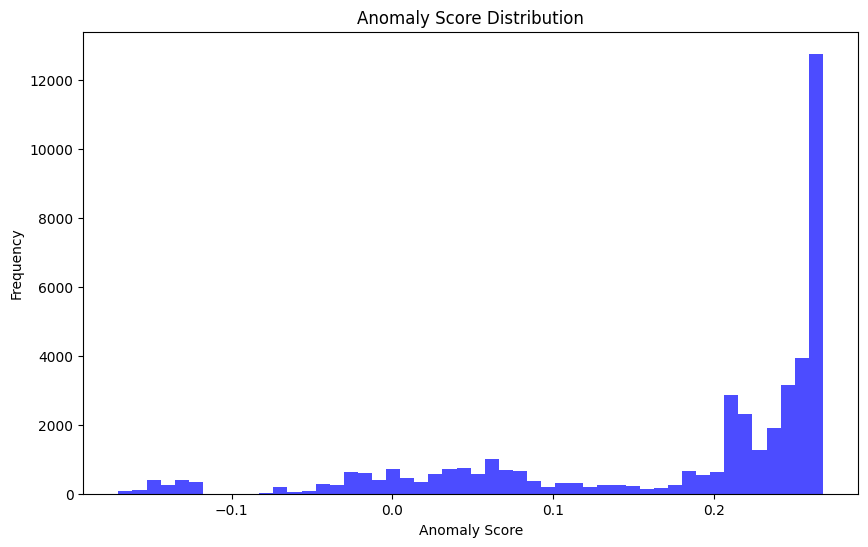

Estimated contamination: 0.03607629929966826
Anomalies detected:
             lat         lng  anomaly     score
32062  35.851939  129.264252       -1 -0.737020
31947  35.847992  129.258405       -1 -0.733538
32104  35.852167  129.264487       -1 -0.740018
13664  35.836940  129.236682       -1 -0.715402
49856  35.839783  129.236626       -1 -0.714435
...          ...         ...      ...       ...
31599  35.825592  129.224425       -1 -0.744937
49958  35.841962  129.245350       -1 -0.724658
49883  35.843597  129.236548       -1 -0.715887
31914  35.845457  129.252570       -1 -0.731555
49893  35.843195  129.237444       -1 -0.712504

[399 rows x 4 columns]


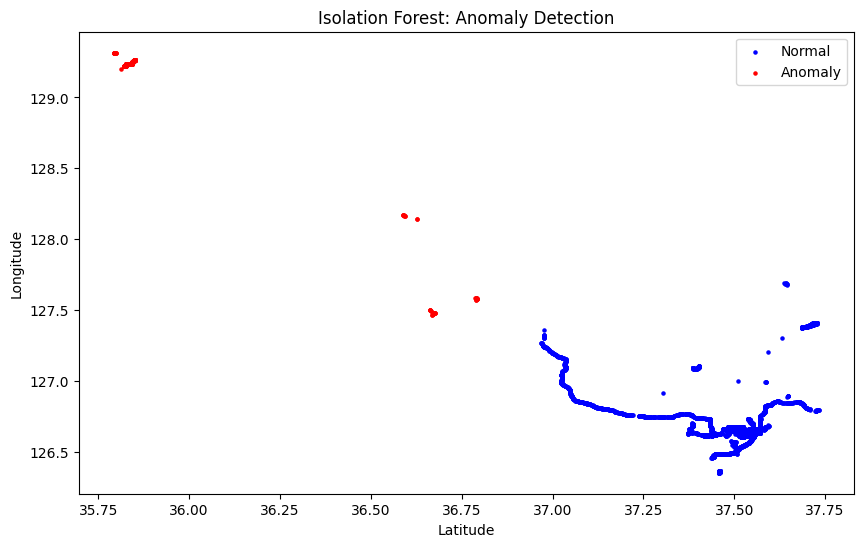

In [2]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# 데이터 로드 및 전처리
data = pd.read_csv(r'combined.csv')
data = data.dropna(subset=['lat', 'lng'])

# 특성 선택
X = data[['lat', 'lng']]

# 데이터 분할
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Isolation Forest 모델 생성 및 학습
iso_forest = IsolationForest(contamination=0.1, random_state=42)
iso_forest.fit(X_train)

# Anomaly score 계산
scores = iso_forest.decision_function(X_train)

# Anomaly score 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(scores, bins=50, color='blue', alpha=0.7)
plt.title('Anomaly Score Distribution')
plt.xlabel('Anomaly Score')
plt.ylabel('Frequency')
plt.show()

# 최적의 임계값 설정 (예시로 -0.1 사용, 필요시 조정)
threshold = -0.1

# 임계값을 사용하여 contamination 값 추정
contamination_estimated = np.mean(scores < threshold)
print("Estimated contamination:", contamination_estimated)

# contamination 값이 0.0 초과 0.5 이하로 조정
contamination_estimated = min(max(contamination_estimated, 0.01), 0.5)

# 추정된 contamination 값으로 모델 재학습
iso_forest = IsolationForest(contamination=contamination_estimated, random_state=42)
iso_forest.fit(X_train)

# 예측 및 점수 계산
predictions = iso_forest.predict(X_test)
scores = iso_forest.score_samples(X_test)

# 예측 결과를 DataFrame으로 변환
X_test_df = X_test.copy()
X_test_df['anomaly'] = predictions
X_test_df['score'] = scores

# 이상치 결과 필터링
anomalies = X_test_df[X_test_df['anomaly'] == -1]

# 원본 데이터에 'output' 열 추가
data['output'] = 1  # 기본값을 1로 설정

# 테스트 데이터의 인덱스를 이용하여 'output' 값 업데이트
data.loc[X_test_df.index, 'output'] = X_test_df['anomaly']

# 'anomaly' 값이 -1이면 'output'을 -1로 변경
data['output'] = data['output'].apply(lambda x: -1 if x == -1 else 1)

# 변경된 DataFrame을 CSV 파일로 저장
data.to_csv('combined3.csv', index=False)

# 이상치 및 점수 출력
print("Anomalies detected:")
print(anomalies)

# 시각화
plt.figure(figsize=(10, 6))
plt.scatter(X_test_df[X_test_df['anomaly'] == 1]['lat'], X_test_df[X_test_df['anomaly'] == 1]['lng'], color='blue', s=5, label='Normal')
plt.scatter(anomalies['lat'], anomalies['lng'], color='red', s=5, label='Anomaly')
plt.title('Isolation Forest: Anomaly Detection')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
plt.legend()
plt.show()
